In [1]:
import os

import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True


using device: cuda


In [3]:
np.random.seed(3)

def show_anns(anns, borders=True):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:, :, 3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask 
        if borders:
            import cv2
            contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
            # Try to smooth contours
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            cv2.drawContours(img, contours, -1, (0, 0, 1, 0.4), thickness=1) 

    ax.imshow(img)

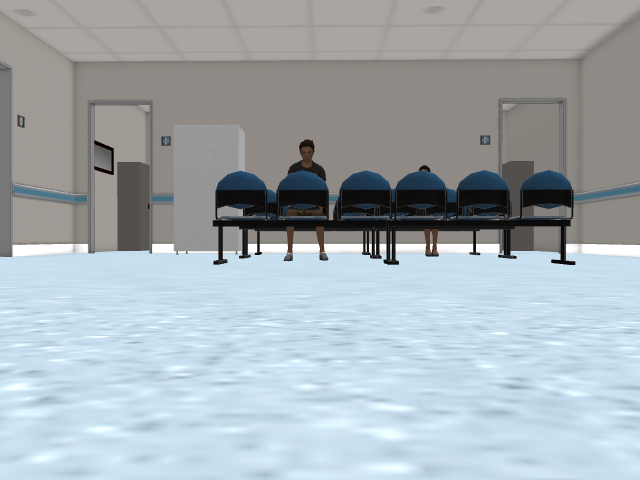

In [4]:
image = Image.open('../images/1.png')
image

In [5]:
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

model_name = 'base_plus'

if model_name == 'base_plus':
    sam2_checkpoint = "../checkpoints/sam2.1_hiera_base_plus.pt"
    model_cfg = "configs/sam2.1/sam2.1_hiera_b+.yaml"
elif model_name == 'small':
    sam2_checkpoint = "../checkpoints/sam2.1_hiera_small.pt"
    model_cfg = "configs/sam2.1/sam2.1_hiera_s.yaml"

sam2 = build_sam2(model_cfg, sam2_checkpoint, device=device, apply_postprocessing=False)

In [6]:
mask_generator = SAM2AutomaticMaskGenerator(
    model=sam2,
    points_per_side=64,
    points_per_batch=128,
    pred_iou_thresh=0.7,
    stability_score_thresh=0.92,
    stability_score_offset=0.7,
    crop_n_layers=1,
    box_nms_thresh=0.7,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=25.0,
    use_m2m=True,
)

In [7]:
image_ar = np.array(image.convert("RGB"))
masks = mask_generator.generate(image_ar)

/home/ps2-mid/miniconda3/envs/vl2/lib/python3.10/site-packages/sam2/sam2_image_predictor.py:431: UserWarning: /home/ps2-mid/miniconda3/envs/vl2/bin/../lib/libstdc++.so.6: version `GLIBCXX_3.4.32' not found (required by /home/ps2-mid/miniconda3/envs/vl2/lib/python3.10/site-packages/sam2/_C.so)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  masks = self._transforms.postprocess_masks(


In [8]:
print(len(masks))
print(masks[0].keys())

176
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


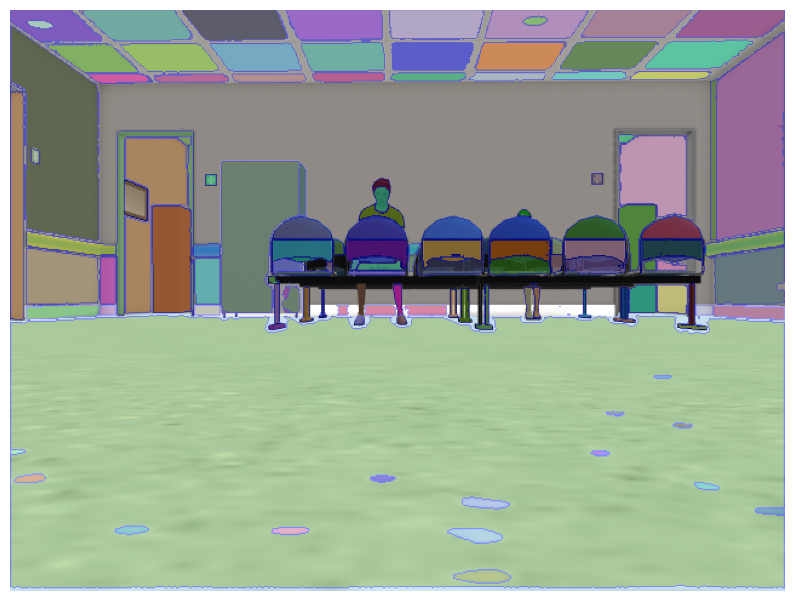

In [9]:
plt.figure(figsize=(10, 10))
plt.imshow(image_ar)
show_anns(masks)
plt.axis('off')
plt.show() 